In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from IPython.display import HTML
import pandas as pd
import matplotlib.animation

# Kalman filter for a constant acceleration model

![Kalman Filter](Kalman-Filter-Step.png)

## State Vector:

Constant Acceleration Model for Motion in 3D

$$x= \left[ \matrix{ x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z \\ \ddot x \\ \ddot y \\ \ddot z} \right]$$


Formal Definition:

$$x_{k+1} = A \cdot x_{k}$$

We assumed $B=0$


$$x_{k+1} = \begin{bmatrix}1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 & 0 & 0 \\ 0 & 1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 & 0 \\ 0 & 0 & 1 & 0 & 0 & \Delta t & 0 & 0 & \frac{1}{2}\Delta t^2 \\ 0 & 0 & 0 & 1 & 0 & 0 & \Delta t & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 & 0 & \Delta t & 0 \\ 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & \Delta t \\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ z \\ \dot x \\ \dot y \\ \dot z \\ \ddot x \\ \ddot y \\ \ddot z\end{bmatrix}_{k}$$

$$y = H \cdot x$$

Position ($x$ & $y$ & $z$) is measured with vision system:

You may change this based on the measurments!

$$y = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \cdot x$$

In [2]:
state_num = 9;

### Initial Uncertainty

In [3]:
P = 1000.0*np.eye(state_num)
print(P, P.shape)

[[ 1000.     0.     0.     0.     0.     0.     0.     0.     0.]
 [    0.  1000.     0.     0.     0.     0.     0.     0.     0.]
 [    0.     0.  1000.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.  1000.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.  1000.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.  1000.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0.  1000.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.  1000.     0.]
 [    0.     0.     0.     0.     0.     0.     0.     0.  1000.]] (9, 9)


### Dynamic Matrix (A)

In [4]:
dt = 0.01 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, 0.0, dt, 0.0, 0.0, 1/2.0*dt**2, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,  dt],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e-02
    0.00000000e+00   0.00000000e+00   5.00000000e-05   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e-02   0.00000000e+00   0.00000000e+00   5.00000000e-05
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e-02   0.00000000e+00   0.00000000e+00
    5.00000000e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e-02   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e-02
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e-02]
 [  0.00000000e+00   0.00000000e+00   0.

### Measurement Matrix

Here you can determine, which of the states is covered by a measurement. In this example, the position ($x$ and $y$ and $z$) is measured.

In [5]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
print(H, H.shape)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]] (3, 9)


### Measurement Noise Covariance Matrix $R$

In [6]:
rp = 1.  # Std of Noise of Position Measurement
R = np.matrix([[rp**2, 0.0, 0.0],
               [0.0, rp**2, 0.0],
               [0.0, 0.0, rp**2]])
print(R, R.shape)

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]] (3, 3)


### Process Noise Covariance Matrix $Q$

The Position of the ball can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the acceleration change the position over one timestep dt.

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_a^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & 0.5dt^2 & dt & dt & dt & 1.0 &1.0 & 1.0\end{bmatrix}^T$ and $\sigma_a$ as the acceleration process noise.

In [7]:
sa = 0.1
G = np.matrix([[1/2.0*dt**2],
               [1/2.0*dt**2],
               [1/2.0*dt**2],
               [dt],
               [dt],
               [dt],
               [1.0],
               [1.0],
               [1.0]])
Q = G*G.T*sa**2

print(Q, Q.shape)

[[  2.50000000e-11   2.50000000e-11   2.50000000e-11   5.00000000e-09
    5.00000000e-09   5.00000000e-09   5.00000000e-07   5.00000000e-07
    5.00000000e-07]
 [  2.50000000e-11   2.50000000e-11   2.50000000e-11   5.00000000e-09
    5.00000000e-09   5.00000000e-09   5.00000000e-07   5.00000000e-07
    5.00000000e-07]
 [  2.50000000e-11   2.50000000e-11   2.50000000e-11   5.00000000e-09
    5.00000000e-09   5.00000000e-09   5.00000000e-07   5.00000000e-07
    5.00000000e-07]
 [  5.00000000e-09   5.00000000e-09   5.00000000e-09   1.00000000e-06
    1.00000000e-06   1.00000000e-06   1.00000000e-04   1.00000000e-04
    1.00000000e-04]
 [  5.00000000e-09   5.00000000e-09   5.00000000e-09   1.00000000e-06
    1.00000000e-06   1.00000000e-06   1.00000000e-04   1.00000000e-04
    1.00000000e-04]
 [  5.00000000e-09   5.00000000e-09   5.00000000e-09   1.00000000e-06
    1.00000000e-06   1.00000000e-06   1.00000000e-04   1.00000000e-04
    1.00000000e-04]
 [  5.00000000e-07   5.00000000e-07   5.

### Identity Matrix $I$

In [8]:
I = np.eye(9)
print(I, I.shape)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]] (9, 9)


## Measurements
Synthetically creation of the Position Data for the ball

In [9]:
Hz = 100.0 # Frequency of Vision System
dt = 1.0/Hz
T = 5.0 # s measuremnt time
m = int(T/dt) # number of measurements

px= -2.0 # x Position Start
py= -2.0 # y Position Start
pz= 2.0 # z Position Start

vx = 2.0 # m/s Velocity at the beginning
vy = 2.0 # m/s Velocity
vz = 2.0 # m/s Velocity

c = 0.1 # Drag Resistance Coefficient
d = 0.9 # Damping

Xr=[]
Yr=[]
Zr=[]

for i in range(int(m)):
    accx = -c*vx**2  # Drag Resistance
    
    vx += accx*dt
    px += vx*dt

    accz = -9.806 + c*vz**2 # Gravitation + Drag
    vz += accz*dt
    pz += vz*dt
    
    if pz<0.01:
        vz=-vz*d
        pz+=0.02
    if vx<0.1:
        accx=0.0
        accz=0.0
        
    Xr.append(px)
    Yr.append(py)
    Zr.append(pz)
    
    
sp= 0.1 # Sigma for position noise

Xm = Xr + sp * (np.random.randn(m))
Ym = Yr + sp * (np.random.randn(m))
Zm = Zr + sp * (np.random.randn(m))

    
measurements = np.vstack((Xm,Ym,Zm))

In [10]:
# x = np.matrix([-10.0, -10.0, 10.0, 5.0, 5.0, 5.0, 0.0, 0.0, -9.81]).T
x = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]).T

# Preallocation for Plotting
xt , yt, zt, dxt, dzt, dyt, ddxt, ddyt, ddzt = [],[],[],[],[],[],[],[],[]

#Kalman filter pipeline

for filterstep in range(m):
    
# Adaptive filter    
#    i = 10
#    if filterstep>i:
#        R = np.matrix([[np.std(measurements[0,(n-i):n])**2, 0.0],
#                      [0.0, np.std(measurements[1,(n-i):n])**2]])
        
    # Model the direction switch, when hitting the plate
    if x[2]<0.01:
        x[5]=-x[5]*d
        x[5]+=0.02

    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,filterstep].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
   
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    dxt.append(float(x[3]))
    dyt.append(float(x[4]))
    dzt.append(float(x[5]))
    ddxt.append(float(x[6]))
    ddyt.append(float(x[7]))
    ddzt.append(float(x[8]))

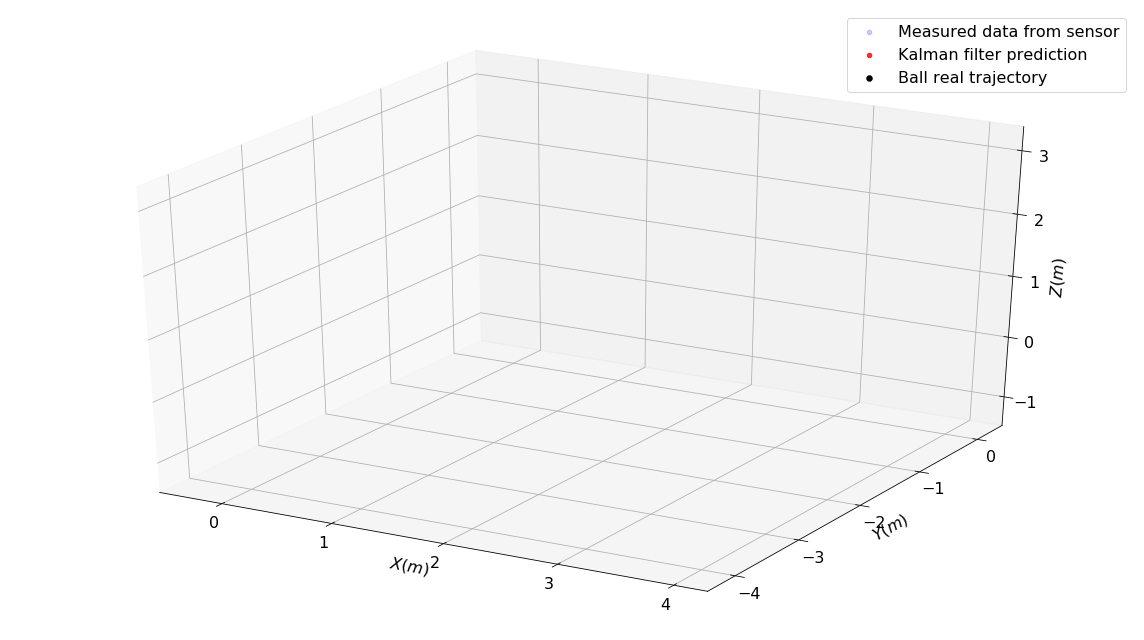

In [11]:
#Animation of resutls:

df_measurement = pd.DataFrame({'x':Xm,'y': Ym,'z' :Zm})
df_kalman = pd.DataFrame({'xt':xt,'yt':yt,'zt' :zt})
df_real = pd.DataFrame({'xr':Xr,'yr':Yr,'zr' :Zr})

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter([],[],[], 'o',  alpha=0.2,  c='blue', label='Measured data from sensor')
sc1 = ax.scatter([],[],[], '.-', alpha=0.8, c='red', label='Kalman filter prediction')
sc2 = ax.scatter([],[],[], '-', linewidth = 2,alpha=1,c='black', label='Ball real trajectory')

def update(i):
    sc._offsets3d = (df_measurement.x.values[:i], df_measurement.y.values[:i], df_measurement.z.values[:i])
    sc1._offsets3d = (df_kalman.xt.values[:i], df_kalman.yt.values[:i], df_kalman.zt.values[:i])
    sc2._offsets3d = (df_real.xr.values[:i], df_real.yr.values[:i], df_real.zr.values[:i])

max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('$X(m)$', fontsize =16)
ax.set_ylabel('$Y(m)$', fontsize =16)
ax.set_zlabel('$Z(m)$', fontsize =16)
plt.legend(loc='best',prop={'size': 16})
plt.tight_layout()

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(df_measurement), interval=30)
HTML(ani.to_html5_video())